# FishEye8K Faster R-CNN Training Notebook

This notebook reproduces the Faster R-CNN training, evaluation, and submission export pipeline for the AI City Challenge 2025 Track 4 (FishEye8K).

> ⚠️ **Before running**: Update the dataset paths in the configuration cell to match your local folder layout.

In [ ]:
# Optional: install/update dependencies inside this environment
# !pip install -r requirements.txt

In [1]:
import json
import math
import os
import random
from pathlib import Path
from typing import Dict, Iterable, Iterator, List, Tuple

import numpy as np
import torch
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights, fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_convert
import torchvision.transforms.functional as F

## Configuration

In [2]:
# Update these paths to point to your local copies
DATA_ROOT = Path(r'/kaggle/input/fisheye8k/Fisheye8K')
TRAIN_IMAGES = DATA_ROOT / 'train' / 'images'
TRAIN_ANN = DATA_ROOT / 'train' / 'train.json'
VAL_IMAGES = DATA_ROOT / 'test' / 'images'
VAL_ANN = DATA_ROOT / 'test' / 'test.json'

# FishEye1kEval (evaluation) resources
FISHEYE1K_IMAGES = Path(r'/kaggle/input/fisheye1k/Fisheye1K/images')
FISHEYE1K_GT = Path(r'/kaggle/input/fisheye1k/Fisheye1K/groundtruth.json')  # edit if stored elsewhere

OUTPUT_DIR = Path('/kaggle/working/notebook_runs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
EPOCHS = 10
BATCH_SIZE = 4
LEARNING_RATE = 0.005
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9
LR_STEPS = [16, 22]
LR_GAMMA = 0.1
PRINT_FREQ = 50
MIN_SCORE = 0.05
NUM_WORKERS = 3  # reduce to 0 if running into multiprocessing issues

In [3]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(SEED)

## Dataset & Transforms

In [4]:
class FishEyeDetectionDataset(torch.utils.data.Dataset):
    """COCO-style dataset wrapper for the FishEye8K benchmark."""

    def __init__(
        self,
        image_dir: str | Path,
        annotation_file: str | Path,
        transforms=None,
        include_crowd: bool = False,
    ) -> None:
        self.image_dir = Path(image_dir)
        self.annotation_path = Path(annotation_file)
        if not self.image_dir.is_dir():
            raise FileNotFoundError(f"Image directory not found: {self.image_dir}")
        if not self.annotation_path.is_file():
            raise FileNotFoundError(f"Annotation file not found: {self.annotation_path}")

        self.coco = COCO(str(self.annotation_path))
        self.ids: List[int] = sorted(self.coco.getImgIds())
        self.transforms = transforms
        self.include_crowd = include_crowd

        categories = self.coco.loadCats(self.coco.getCatIds())
        categories = sorted(categories, key=lambda c: c['id'])
        self.category_id_to_label: Dict[int, int] = {
            category['id']: idx + 1 for idx, category in enumerate(categories)
        }
        self.label_to_category_id: Dict[int, int] = {
            label: category_id for category_id, label in self.category_id_to_label.items()
        }
        self.label_to_name: Dict[int, str] = {
            self.category_id_to_label[category['id']]: category['name'] for category in categories
        }

        missing_files = [
            img_info['file_name']
            for img_info in self.coco.loadImgs(self.ids)
            if not (self.image_dir / img_info['file_name']).is_file()
        ]
        if missing_files:
            raise FileNotFoundError(
                "Missing image files referenced in annotations: "
                + ', '.join(missing_files[:5])
                + (' ...' if len(missing_files) > 5 else '')
            )

    def __len__(self) -> int:
        return len(self.ids)

    def _load_image(self, image_id: int) -> Image.Image:
        img_info = self.coco.loadImgs(image_id)[0]
        img_path = self.image_dir / img_info['file_name']
        image = Image.open(img_path).convert('RGB')
        return image

    def _load_target(self, image_id: int) -> Dict[str, torch.Tensor]:
        annotation_ids = self.coco.getAnnIds(imgIds=[image_id], iscrowd=None if not self.include_crowd else None)
        annotations = self.coco.loadAnns(annotation_ids)

        boxes: List[List[float]] = []
        labels: List[int] = []
        areas: List[float] = []
        iscrowd: List[int] = []

        for annotation in annotations:
            x_min, y_min, width, height = annotation['bbox']
            if width <= 0 or height <= 0:
                continue

            boxes.append([x_min, y_min, x_min + width, y_min + height])
            category_id = annotation['category_id']
            labels.append(self.category_id_to_label[category_id])
            areas.append(float(annotation.get('area', width * height)))
            iscrowd.append(int(annotation.get('iscrowd', 0)))

        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([image_id], dtype=torch.int64),
            'area': torch.as_tensor(areas, dtype=torch.float32),
            'iscrowd': torch.as_tensor(iscrowd, dtype=torch.int64),
        }

        img_info = self.coco.loadImgs(image_id)[0]
        target['orig_size'] = torch.as_tensor([img_info['height'], img_info['width']], dtype=torch.int64)
        target['file_name'] = img_info['file_name']

        if target['boxes'].numel() == 0:
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            target['labels'] = torch.zeros((0,), dtype=torch.int64)
            target['area'] = torch.zeros((0,), dtype=torch.float32)
            target['iscrowd'] = torch.zeros((0,), dtype=torch.int64)

        return target

    def __getitem__(self, index: int):
        image_id = self.ids[index]
        image = self._load_image(image_id)
        target = self._load_target(image_id)

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def get_img_ids(self) -> List[int]:
        return list(self.ids)

    def get_category_mappings(self) -> Dict[str, Dict[int, int]]:
        return {
            'category_id_to_label': self.category_id_to_label,
            'label_to_category_id': self.label_to_category_id,
            'label_to_name': self.label_to_name,
        }

    def save_category_mapping(self, output_path: Path | str) -> None:
        data = {
            'category_id_to_label': self.category_id_to_label,
            'label_to_category_id': self.label_to_category_id,
            'label_to_name': self.label_to_name,
        }
        Path(output_path).write_text(json.dumps(data, indent=2))

In [5]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for transform in self.transforms:
            image, target = transform(image, target)
        return image, target


class ToTensor:
    def __call__(self, image, target):
        return F.to_tensor(image), target


class RandomHorizontalFlip:
    def __init__(self, prob: float = 0.5):
        self.prob = prob

    def __call__(self, image, target):
        if torch.rand(1) < self.prob:
            if isinstance(image, torch.Tensor):
                width = image.shape[-1]
                image = image.flip(-1)
            else:
                width = image.width
                image = F.hflip(image)

            boxes = target['boxes']
            if boxes.numel() > 0:
                xmin = width - boxes[:, 2]
                xmax = width - boxes[:, 0]
                boxes[:, 0] = xmin
                boxes[:, 2] = xmax
                target['boxes'] = boxes
        return image, target


train_transforms = Compose([ToTensor(), RandomHorizontalFlip(prob=0.5)])
val_transforms = Compose([ToTensor()])

## Training Utilities

In [6]:
from collections import defaultdict, deque

In [7]:
class SmoothedValue:
    def __init__(self, window_size: int = 20, fmt: str = '{median:.4f} ({global_avg:.4f})') -> None:
        self.deque: deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value: float, n: int = 1) -> None:
        self.deque.append(value)
        self.count += n
        self.total += value * n

    @property
    def median(self) -> float:
        if not self.deque:
            return 0.0
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self) -> float:
        if not self.deque:
            return 0.0
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self) -> float:
        return self.total / max(1, self.count)

    @property
    def max(self) -> float:
        return max(self.deque) if self.deque else 0.0

    @property
    def value(self) -> float:
        return self.deque[-1] if self.deque else 0.0

    def __str__(self) -> str:
        return self.fmt.format(median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value)


class MetricLogger:
    def __init__(self, delimiter: str = '  ') -> None:
        self.meters: Dict[str, SmoothedValue] = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs) -> None:
        for key, value in kwargs.items():
            if isinstance(value, torch.Tensor):
                value = value.item()
            self.meters[key].update(value)

    def __getattr__(self, attr: str) -> SmoothedValue:
        if attr in self.meters:
            return self.meters[attr]
        raise AttributeError(attr)

    def __str__(self) -> str:
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f'{name}: {meter}')
        return self.delimiter.join(loss_str)

    def log_every(self, iterable: Iterable, print_freq: int, header: str = '') -> Iterator:
        for i, obj in enumerate(iterable):
            yield obj
            if i % print_freq == 0:
                print(f"{header}[{i}/{len(iterable) if hasattr(iterable, '__len__') else '?'}]  {self}")

def collate_fn(batch):
    return tuple(zip(*batch))

def warmup_lr_scheduler(optimizer: torch.optim.Optimizer, warmup_iters: int, warmup_factor: float):
    def f(x):
        if x >= warmup_iters:
            return 1.0
        alpha = float(x) / float(warmup_iters)
        return warmup_factor * (1 - alpha) + alpha
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

def save_checkpoint(state: Dict, filename: Path | str) -> None:
    torch.save(state, filename)

## Training & Evaluation Loops

In [8]:
def _move_to_device(target: Dict, device: torch.device) -> Dict:
    moved: Dict = {}
    for key, value in target.items():
        if isinstance(value, torch.Tensor):
            moved[key] = value.to(device)
        else:
            moved[key] = value
    return moved


@torch.no_grad()
def _sanitize_image_id(raw_id):
    if isinstance(raw_id, torch.Tensor):
        return int(raw_id.view(-1)[0].item())
    if isinstance(raw_id, (list, tuple)):
        return int(raw_id[0])
    return int(raw_id)


def train_one_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    data_loader: DataLoader,
    device: torch.device,
    epoch: int,
    print_freq: int = 20,
    scaler: torch.cuda.amp.GradScaler | None = None,
    clip_grad_norm: float | None = None,
) -> Dict[str, float]:
    model.train()
    metric_logger = MetricLogger(delimiter='  ')
    header = f'Epoch: [{epoch}]'

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = [image.to(device) for image in images]
        targets = [_move_to_device(target, device) for target in targets]

        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()
        if not math.isfinite(loss_value):
            raise RuntimeError(f'Non-finite loss {loss_value} encountered. Stopping training.')

        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            scaler.scale(losses).backward()
            if clip_grad_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            if clip_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
            optimizer.step()

        metric_logger.update(loss=loss_value, lr=optimizer.param_groups[0]['lr'])
        for key, value in loss_dict.items():
            metric_logger.update(**{f'loss_{key}': value})

    return {key: meter.global_avg for key, meter in metric_logger.meters.items()}


@torch.inference_mode()
def evaluate(
    model: torch.nn.Module,
    data_loader: DataLoader,
    device: torch.device,
    dataset: FishEyeDetectionDataset,
    score_threshold: float = 0.05,
) -> Tuple[Dict[str, float], List[Dict]]:
    model.eval()
    metric_logger = MetricLogger(delimiter='  ')
    header = 'Eval:'

    all_detections: List[Dict] = []
    mappings = dataset.get_category_mappings()
    label_to_category_id = mappings['label_to_category_id']

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = [image.to(device) for image in images]
        outputs = model(images)

        for target, output in zip(targets, outputs):
            image_id = _sanitize_image_id(target['image_id'])
            boxes = output['boxes'].detach().cpu()
            scores = output['scores'].detach().cpu()
            labels = output['labels'].detach().cpu()

            keep = scores >= score_threshold
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

            if boxes.numel() == 0:
                continue

            order = torch.argsort(scores, descending=True)
            boxes = boxes[order]
            scores = scores[order]
            labels = labels[order]

            boxes_xywh = box_convert(boxes, in_fmt='xyxy', out_fmt='xywh').tolist()
            scores_list = scores.tolist()
            labels_list = labels.tolist()

            for box, score, label in zip(boxes_xywh, scores_list, labels_list):
                all_detections.append(
                    {
                        'image_id': image_id,
                        'category_id': label_to_category_id[int(label)],
                        'bbox': [float(x) for x in box],
                        'score': float(score),
                    }
                )

    if len(all_detections) == 0:
        return {}, []

    coco_gt = dataset.coco
    coco_dt = coco_gt.loadRes(all_detections)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    stats = coco_eval.stats
    metrics = {
        'AP': float(stats[0]),
        'AP50': float(stats[1]),
        'AP75': float(stats[2]),
        'APS': float(stats[3]),
        'APM': float(stats[4]),
        'APL': float(stats[5]),
        'AR1': float(stats[6]),
        'AR10': float(stats[7]),
        'AR100': float(stats[8]),
    }
    return metrics, all_detections

## Model Builder

In [9]:
def build_faster_rcnn(
    num_classes: int,
    pretrained: bool = True,
    freeze_backbone: bool = False,
) -> torch.nn.Module:
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1 if pretrained else None
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    if freeze_backbone:
        for parameter in model.backbone.parameters():
            parameter.requires_grad = False
    return model

## Build Datasets & Dataloaders

In [10]:
train_dataset = FishEyeDetectionDataset(TRAIN_IMAGES, TRAIN_ANN, transforms=train_transforms)
val_dataset = FishEyeDetectionDataset(VAL_IMAGES, VAL_ANN, transforms=val_transforms)

num_classes = len(train_dataset.get_category_mappings()['label_to_name']) + 1
print(f"Detected {num_classes - 1} foreground classes.")

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
Detected 5 foreground classes.


In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)
print(f"Train images: {len(train_dataset)}, Val images: {len(val_dataset)}")

Train images: 5288, Val images: 2712


## Initialize Model & Optimizer

In [12]:
model = build_faster_rcnn(num_classes=num_classes, pretrained=True, freeze_backbone=False)
model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=LR_STEPS, gamma=LR_GAMMA)
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 182MB/s]  
/tmp/ipykernel_48/362873031.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


## Training Loop

In [13]:
best_ap50 = 0.0
metrics_history = []

for epoch in range(EPOCHS):
    train_metrics = train_one_epoch(
        model=model,
        optimizer=optimizer,
        data_loader=train_loader,
        device=DEVICE,
        epoch=epoch,
        print_freq=PRINT_FREQ,
        scaler=scaler,
    )

    lr_scheduler.step()

    metrics, detections = evaluate(
        model=model,
        data_loader=val_loader,
        device=DEVICE,
        dataset=val_dataset,
        score_threshold=MIN_SCORE,
    )

    metrics_history.append({'epoch': epoch, 'train': train_metrics, 'val': metrics})
    ap50 = metrics.get('AP50', 0.0) if metrics else 0.0
    is_best = ap50 > best_ap50
    if is_best:
        best_ap50 = ap50

    checkpoint_state = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'lr_scheduler_state': lr_scheduler.state_dict(),
        'best_ap50': best_ap50,
        'train_metrics': train_metrics,
        'val_metrics': metrics,
        'config': {
            'epochs': EPOCHS,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'weight_decay': WEIGHT_DECAY,
            'momentum': MOMENTUM,
            'lr_steps': LR_STEPS,
            'lr_gamma': LR_GAMMA,
            'min_score': MIN_SCORE,
        },
    }
    if scaler is not None:
        checkpoint_state['scaler_state'] = scaler.state_dict()

    last_path = OUTPUT_DIR / 'model_last.pth'
    save_checkpoint(checkpoint_state, last_path)

    if is_best:
        best_path = OUTPUT_DIR / 'model_best.pth'
        save_checkpoint(checkpoint_state, best_path)
        print(f"Saved best checkpoint to {best_path}")

    epoch_path = OUTPUT_DIR / f'model_epoch_{epoch:03d}.pth'
    save_checkpoint(checkpoint_state, epoch_path)
    (OUTPUT_DIR / f'val_predictions_epoch_{epoch:03d}.json').write_text(json.dumps(detections, indent=2))

print(f"Training complete. Best AP50: {best_ap50:.4f}")

/tmp/ipykernel_48/1142590638.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0][0/1322]  loss: 5.0392 (5.0392)  lr: 0.0050 (0.0050)  loss_loss_classifier: 2.0455 (2.0455)  loss_loss_box_reg: 0.4639 (0.4639)  loss_loss_objectness: 2.2755 (2.2755)  loss_loss_rpn_box_reg: 0.2543 (0.2543)
Epoch: [0][50/1322]  loss: 1.2033 (1.5373)  lr: 0.0050 (0.0050)  loss_loss_classifier: 0.4177 (0.6022)  loss_loss_box_reg: 0.5766 (0.5837)  loss_loss_objectness: 0.0795 (0.2039)  loss_loss_rpn_box_reg: 0.1193 (0.1475)
Epoch: [0][100/1322]  loss: 0.9287 (1.2720)  lr: 0.0050 (0.0050)  loss_loss_classifier: 0.2992 (0.4729)  loss_loss_box_reg: 0.4607 (0.5407)  loss_loss_objectness: 0.0484 (0.1342)  loss_loss_rpn_box_reg: 0.0922 (0.1241)
Epoch: [0][150/1322]  loss: 0.8464 (1.1405)  lr: 0.0050 (0.0050)  loss_loss_classifier: 0.2680 (0.4096)  loss_loss_box_reg: 0.4302 (0.5070)  loss_loss_objectness: 0.0465 (0.1065)  loss_loss_rpn_box_reg: 0.1158 (0.1173)
Epoch: [0][200/1322]  loss: 0.8595 (1.0666)  lr: 0.0050 (0.0050)  loss_loss_classifier: 0.2648 (0.3737)  loss_loss_box_reg: 0.4

## Evaluate a Saved Checkpoint

In [14]:
checkpoint_path = OUTPUT_DIR / 'model_best.pth'
assert checkpoint_path.is_file(), 'Checkpoint not found. Train the model first.'

model_eval = build_faster_rcnn(num_classes=num_classes, pretrained=False)
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model_eval.load_state_dict(checkpoint['model_state'])
model_eval.to(DEVICE)

metrics_best, detections_best = evaluate(
    model=model_eval,
    data_loader=val_loader,
    device=DEVICE,
    dataset=val_dataset,
    score_threshold=MIN_SCORE,
)
print('Validation metrics for best checkpoint:')
for key, value in metrics_best.items():
    print(f"  {key}: {value:.4f}")

Eval:[0/2712]  
Eval:[100/2712]  
Eval:[200/2712]  
Eval:[300/2712]  
Eval:[400/2712]  
Eval:[500/2712]  
Eval:[600/2712]  
Eval:[700/2712]  
Eval:[800/2712]  
Eval:[900/2712]  
Eval:[1000/2712]  
Eval:[1100/2712]  
Eval:[1200/2712]  
Eval:[1300/2712]  
Eval:[1400/2712]  
Eval:[1500/2712]  
Eval:[1600/2712]  
Eval:[1700/2712]  
Eval:[1800/2712]  
Eval:[1900/2712]  
Eval:[2000/2712]  
Eval:[2100/2712]  
Eval:[2200/2712]  
Eval:[2300/2712]  
Eval:[2400/2712]  
Eval:[2500/2712]  
Eval:[2600/2712]  
Eval:[2700/2712]  
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.19s).
Accumulating evaluation results...
DONE (t=1.49s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[

## Export Predictions for FishEye1kEval

In [15]:
def load_image_id_map(groundtruth_path: Path) -> Dict[str, int]:
    data = json.loads(groundtruth_path.read_text())
    if 'images' not in data:
         raise KeyError("Groundtruth JSON missing 'images' field.")
    return {image['file_name']: int(image['id']) for image in data['images']}


class FishEyeEvalDataset(Dataset):
    def __init__(self, image_dir: str | Path, image_id_map: Dict[str, int], transforms=None) -> None:
        self.image_dir = Path(image_dir)
        if not self.image_dir.is_dir():
            raise FileNotFoundError(f'Image directory not found: {self.image_dir}')
        self.image_paths = sorted([p for p in self.image_dir.iterdir() if p.suffix.lower() in {'.png', '.jpg', '.jpeg'}])
        if not self.image_paths:
            raise RuntimeError(f'No images found in {self.image_dir}')
        self.image_id_map = image_id_map
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, index: int):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        file_name = image_path.name
        image_id = self.image_id_map.get(file_name)
        if image_id is None:
            raise KeyError(f'Image ID for {file_name} not found in groundtruth metadata.')
        target = {'image_id': image_id, 'file_name': file_name}
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        return image, target


def run_inference(
    model: torch.nn.Module,
    data_loader: DataLoader,
    device: torch.device,
    label_to_category_id: Dict[int, int],
    min_score: float = 0.05,
    max_detections: int | None = None,
) -> List[Dict]:
    model.eval()
    detections: List[Dict] = []

    with torch.inference_mode():
        for batch_idx, (images, targets) in enumerate(data_loader):
            images = [image.to(device) for image in images]
            outputs = model(images)

            for target, output in zip(targets, outputs):
                image_id = int(target['image_id'])
                boxes = output['boxes'].detach().cpu()
                scores = output['scores'].detach().cpu()
                labels = output['labels'].detach().cpu()

                keep = scores >= min_score
                boxes = boxes[keep]
                scores = scores[keep]
                labels = labels[keep]

                order = torch.argsort(scores, descending=True)
                if max_detections is not None and max_detections > 0:
                    order = order[:max_detections]
                boxes = boxes[order]
                scores = scores[order]
                labels = labels[order]

                if boxes.numel() == 0:
                    continue

                boxes_xywh = box_convert(boxes, in_fmt='xyxy', out_fmt='xywh').tolist()
                for box, score, label in zip(boxes_xywh, scores.tolist(), labels.tolist()):
                    detections.append(
                        {
                            'image_id': image_id,
                            'category_id': int(label_to_category_id[int(label)]),
                            'bbox': [float(x) for x in box],
                            'score': float(score),
                        }
                    )

            if (batch_idx + 1) % 50 == 0:
                print(f'Processed {batch_idx + 1} batches ...')

    return detections

In [ ]:
# Prepare evaluation dataset and run inference
category_map_path = OUTPUT_DIR / 'category_mapping.json'
train_dataset.save_category_mapping(category_map_path)
category_mapping = json.loads(category_map_path.read_text())
label_to_category_id = {int(k): int(v) for k, v in category_mapping['label_to_category_id'].items()}

image_id_map = load_image_id_map(FISHEYE1K_GT)
fisheye_eval_dataset = FishEyeEvalDataset(FISHEYE1K_IMAGES, image_id_map, transforms=val_transforms)
fisheye_eval_loader = DataLoader(
    fisheye_eval_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)

model_export = build_faster_rcnn(num_classes=num_classes, pretrained=False)
model_export.load_state_dict(torch.load(OUTPUT_DIR / 'model_best.pth', map_location='cpu')['model_state'])
model_export.to(DEVICE)

export_detections = run_inference(
    model=model_export,
    data_loader=fisheye_eval_loader,
    device=DEVICE,
    label_to_category_id=label_to_category_id,
    min_score=0.01,
    max_detections=300,
)

export_path = OUTPUT_DIR / 'FishEye1kEval_detections.json'
export_path.write_text(json.dumps(export_detections, indent=2))
print(f'Saved {len(export_detections)} detections to {export_path}')

## Next Steps

- Adjust hyperparameters (epochs, learning rate, augmentations) and re-run cells to improve accuracy.
- Use the official FishEye8K evaluation scripts to compute the challenge metrics on the exported JSON.
- Consider extending the notebook with richer data augmentation or advanced detectors if you need higher leaderboard scores.

In [16]:

# Try to collect training history from common variable names or logs and plot
import os, glob, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _maybe_np(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x)

def collect_histories(namespace: dict):
    cand_keys = [
        # Typical dict of lists
        "history", "train_history", "logs", "metrics",
        # Typical simple loss list
        "loss_history", "train_losses", "losses",
    ]
    found = {}
    for k in cand_keys:
        if k in namespace:
            found[k] = namespace[k]
    # Also search patterns like '*_loss_history'
    for k,v in list(namespace.items()):
        if isinstance(k, str) and re.search(r"loss(_history|es)?$", k):
            found[k] = v
    return found

def to_frame(obj):
    # Convert a history-like object to a tidy DataFrame
    if obj is None:
        return None
    if isinstance(obj, pd.DataFrame):
        return obj.copy()
    if isinstance(obj, dict):
        # dict of lists/tensors
        d = {k: _maybe_np(v) for k,v in obj.items() if hasattr(v, "__len__")}
        try:
            return pd.DataFrame(d)
        except Exception:
            pass
        # dict of scalars per step (unlikely)
        return pd.DataFrame([d])
    if isinstance(obj, (list, tuple)):
        try:
            return pd.DataFrame({"loss": [_maybe_np(x).item() if np.size(_maybe_np(x))==1 else float(np.mean(_maybe_np(x))) for x in obj]})
        except Exception:
            return pd.DataFrame({"loss": obj})
    return None

# 1) Try variables in the current namespace
_ns = globals().copy()
histories = collect_histories(_ns)
dfs = []
for name, val in histories.items():
    df = to_frame(val)
    if df is not None and not df.empty:
        df = df.copy()
        df["source"] = name
        df["step"] = np.arange(len(df))
        dfs.append(df)

# 2) Try common CSV/JSON logs in the working directory
csv_candidates = glob.glob("**/*train*.csv", recursive=True) + glob.glob("**/*log*.csv", recursive=True)
for p in csv_candidates[:3]:  # keep it light
    try:
        df = pd.read_csv(p)
        if not df.empty:
            df["source"] = f"file:{os.path.basename(p)}"
            if "step" not in df.columns:
                df["step"] = np.arange(len(df))
            dfs.append(df)
    except Exception:
        pass

json_candidates = glob.glob("**/*history*.json", recursive=True) + glob.glob("**/*metrics*.json", recursive=True)
for p in json_candidates[:3]:
    try:
        with open(p, "r", encoding="utf-8") as f:
            js = json.load(f)
        df = to_frame(js)
        if df is not None and not df.empty:
            df["source"] = f"file:{os.path.basename(p)}"
            if "step" not in df.columns:
                df["step"] = np.arange(len(df))
            dfs.append(df)
    except Exception:
        pass

if not dfs:
    print("⚠️ No obvious training logs found. If you have a list of losses (e.g. `loss_history`) or a dict `history`, re-run this cell after they're in memory.")
else:
    # Merge, harmonize common columns
    plot_cols = []
    merged = []
    for df in dfs:
        cols = [c for c in df.columns if c.lower() in {"loss","cls_loss","box_reg","rpn_cls","rpn_bbox","lr"}]
        if not cols:
            # fallback: guess numeric columns
            cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c not in {"step"}]
        if not cols:
            continue
        for c in cols:
            sub = df[["step", c, "source"]].rename(columns={c: "value"}).copy()
            sub["metric"] = c
            merged.append(sub)
            plot_cols.append(c)
    if not merged:
        print("⚠️ Found logs but did not recognize any numeric metric columns.")
    else:
        data = pd.concat(merged, ignore_index=True)
        # Plot each metric on its own figure
        for metric, g in data.groupby("metric"):
            plt.figure()
            for src, gg in g.groupby("source"):
                gg = gg.sort_values("step")
                plt.plot(gg["step"], gg["value"], label=src)
            plt.xlabel("Step / Epoch")
            plt.ylabel(metric)
            plt.title(f"Training Curve: {metric}")
            plt.legend(loc="best")
            plt.grid(True)
            plt.show()


⚠️ No obvious training logs found. If you have a list of losses (e.g. `loss_history`) or a dict `history`, re-run this cell after they're in memory.


In [17]:

import inspect
import torch

def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

model_candidates = []
for name in ["model","net","detector","fasterrcnn","faster_rcnn","frcnn"]:
    if name in globals():
        model_candidates.append((name, globals()[name]))

chosen_name, chosen_model = None, None
for name, m in model_candidates:
    if hasattr(m, "parameters"):
        chosen_name, chosen_model = name, m
        break

if chosen_model is None:
    print("⚠️ Could not find a model variable (tried names like `model`, `net`). Assign your Faster R-CNN to `model` and re-run.")
else:
    total, trainable = count_params(chosen_model)
    print(f"Model variable: {chosen_name}")
    print(f"Total params: {total:,}")
    print(f"Trainable params: {trainable:,}")
    try:
        print("\nModel structure:\n", chosen_model)
    except Exception as e:
        print("Model structure print failed:", e)

    # Try a minimal forward on a single dummy image to estimate latency (optional)
    try:
        chosen_model.eval()
        device = next(chosen_model.parameters()).device
        dummy = torch.rand(3, 640, 640, device=device)  # CHW
        with torch.inference_mode():
            _ = chosen_model([dummy])  # torchvision detection expects list of tensors
        print("✅ Forward pass on dummy image succeeded.")
    except Exception as e:
        print("ℹ️ Skipping dummy forward:", e)


Model variable: model
Total params: 43,276,653
Trainable params: 43,051,309

Model structure:
 FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

Using dataset: val_dataset, length=2712


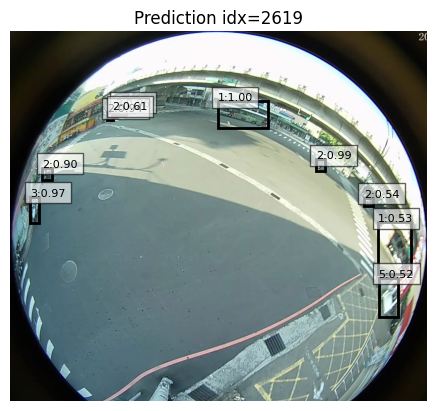

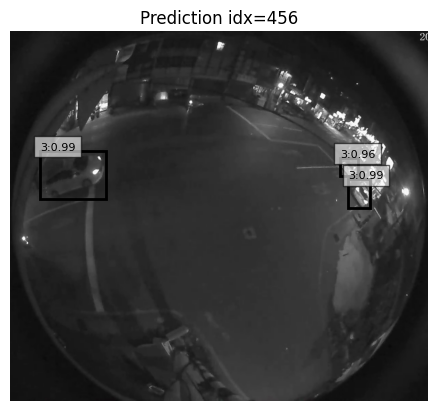

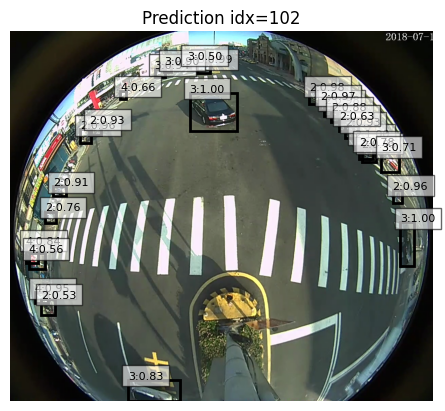

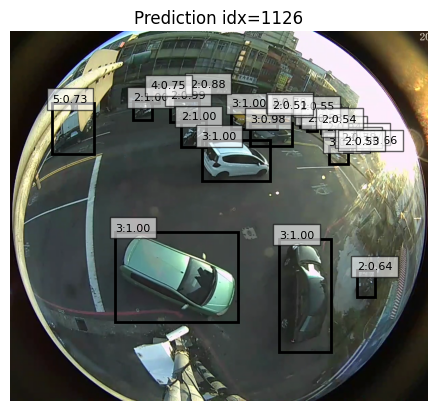

In [18]:

import random, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def _pick_dataset():
    # Try common names
    for name in ["val_dataset","dataset_val","dataset_valid","dataset_test","test_dataset","valid_dataset","dataset","train_dataset"]:
        if name in globals():
            ds = globals()[name]
            try:
                # need __len__ and __getitem__
                _ = len(ds)
                _ = ds[0]
                return name, ds
            except Exception:
                pass
    return None, None

def _to_numpy_img(img):
    # Accept PIL, torch.Tensor CHW or HWC
    try:
        import torch
        if isinstance(img, torch.Tensor):
            arr = img.detach().cpu().numpy()
            if arr.ndim == 3 and arr.shape[0] in (1,3):
                arr = np.transpose(arr, (1,2,0))
            return np.clip(arr, 0, 1)
    except Exception:
        pass
    try:
        # PIL
        return np.asarray(img)/255.0 if img.max()>1.0 else np.asarray(img)
    except Exception:
        return np.asarray(img)

def _plot_prediction(ax, img, pred):
    ax.imshow(img)
    if pred and "boxes" in pred and "scores" in pred:
        boxes = pred["boxes"]
        scores = pred["scores"]
        labels = pred.get("labels", None)
        try:
            import torch
            if isinstance(boxes, torch.Tensor): boxes = boxes.detach().cpu().numpy()
            if isinstance(scores, torch.Tensor): scores = scores.detach().cpu().numpy()
            if labels is not None and isinstance(labels, torch.Tensor): labels = labels.detach().cpu().numpy()
        except Exception:
            pass
        keep = scores >= 0.5
        boxes = boxes[keep]
        scores = scores[keep]
        if labels is not None:
            labels = labels[keep]
        for i, b in enumerate(boxes):
            x1,y1,x2,y2 = b
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2)
            ax.add_patch(rect)
            txt = f"{scores[i]:.2f}" if labels is None else f"{int(labels[i])}:{scores[i]:.2f}"
            ax.text(x1, max(0,y1-3), txt, fontsize=8, bbox=dict(facecolor="white", alpha=0.6))

name, ds = _pick_dataset()
if ds is None:
    print("⚠️ Could not find a dataset variable. Please set `val_dataset` or `dataset_test` and re-run.")
else:
    print(f"Using dataset: {name}, length={len(ds)}")
    # find model
    model = globals().get("model", None) or globals().get("net", None)
    if model is None:
        print("⚠️ Model not found (expected `model` or `net`).")
    else:
        model.eval()
        try:
            import torch
            device = next(model.parameters()).device
        except Exception:
            device = "cpu"
        n = min(4, len(ds))
        idxs = random.sample(range(len(ds)), n) if len(ds) >= n else list(range(n))
        fig_count = 0
        for idx in idxs:
            try:
                sample = ds[idx]
                if isinstance(sample, (list, tuple)) and len(sample)>=1:
                    img = sample[0]
                else:
                    img = sample
                # move to device if tensor
                try:
                    import torch
                    if isinstance(img, torch.Tensor):
                        inp = img.to(device)
                    else:
                        # torchvision expects CHW tensor float in [0,1]
                        import torchvision.transforms.functional as F
                        inp = F.to_tensor(img).to(device)
                except Exception:
                    inp = img

                with torch.inference_mode():
                    out = model([inp])[0]
                npimg = _to_numpy_img(img)
                fig = plt.figure()
                ax = plt.gca()
                _plot_prediction(ax, npimg, {k:v for k,v in out.items() if k in ("boxes","scores","labels")})
                plt.title(f"Prediction idx={idx}")
                plt.axis("off")
                plt.show()
                fig_count += 1
            except Exception as e:
                print(f"Skip idx {idx} due to error:", e)
        if fig_count == 0:
            print("⚠️ No figures were produced. Ensure dataset returns image tensors/PIL and the model is on the right device.")


In [19]:

# This is a lightweight scaffold; it will run only if the expected variables/utilities already exist.
try:
    model = globals().get("model", None) or globals().get("net", None)
    data_loader_test = globals().get("data_loader_test", None) or globals().get("val_loader", None)
    coco_evaluator = globals().get("coco_evaluator", None)
    if model is None:
        raise RuntimeError("Model (`model`/`net`) not found in globals.")
    if data_loader_test is None:
        raise RuntimeError("No validation/test DataLoader found (expected `data_loader_test` or `val_loader`).")
    if coco_evaluator is None:
        raise RuntimeError("`coco_evaluator` utility not found in scope.")
    print("Running quick evaluation on a small subset...")
    model.eval()
    import torch
    device = next(model.parameters()).device
    from collections import defaultdict

    # Evaluate on at most 50 images to keep it fast
    limit = 50
    with torch.inference_mode():
        for i, (images, targets) in enumerate(data_loader_test):
            images = [img.to(device) for img in images]
            outputs = model(images)
            outputs = [{k:v.detach().cpu() for k,v in o.items()} for o in outputs]
            coco_evaluator.update(outputs)
            if i*len(images) >= limit:
                break
    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
except Exception as e:
    print("ℹ️ Evaluation scaffold not executed:", e)


ℹ️ Evaluation scaffold not executed: `coco_evaluator` utility not found in scope.
